In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from finder import read_files, parse_annotated, target_classes
from label import Label

In [2]:
SEED=12345
default_label = Label('Misc-exposition')
keep_labels = [Label('Description'), Label('Nomenclature')]

In [3]:
training_files = [f for g in [
    '../data/annotated/journals/Mycotaxon/Vol*/*.ann'
] for f in glob.glob(g)]


In [4]:
len(training_files)

169

In [5]:
paragraphs = list(parse_annotated(read_files(training_files)))

In [6]:
relabeled = list(target_classes(default=default_label, keep=keep_labels, paragraphs=paragraphs))

In [7]:
print(len(relabeled), "paragraphs")
print(relabeled[:5])

79192 paragraphs
[Labels([Label('Misc-exposition')]), Paragraph('\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('ISSN (print) 0093-4666\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('© 2012. Mycotaxon, Ltd.\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('\n'), Pending(None)
]


In [8]:
pp=relabeled[2000]
dir(pp)
print(f"pp.filename: {pp.filename}")
print(f"pp.paragraph_number: {pp.paragraph_number}")
print(f"pp.top_label().label: {pp.top_label().label}")
print(f"pp.empirical_page_number: {pp.empirical_page_number}")
print(f"str(pp): {str(pp)}")
print(f"len(str(pp)): {len(str(pp))}")

pp.filename: ../data/annotated/journals/Mycotaxon/Vol119/s19.txt.ann
pp.paragraph_number: 2000
pp.top_label().label: Misc-exposition
pp.empirical_page_number: 4666
str(pp): There are 114 Mycena species so far recorded in Argentina. Most have been
found in the Andino-Patagonic forest and the Yungas region of northwestern
Argentina, with only six species known from the Paranaense forest (Spegazzini
1926, Wright et al. 2008, Lechner et al. 2006, Wright & Wright 2005, Niveiro
et al. 2010).

len(str(pp)): 318


In [9]:
df = pd.DataFrame({
    'filename': [pp.filename for pp in relabeled],
    'label': [pp.top_label().label if pp.top_label() else None for pp in relabeled],
    'paragraph_number': [pp.paragraph_number for pp in relabeled],
    'page_number': [pp.page_number for pp in relabeled],
    'empirical_page_number': [pp.empirical_page_number for pp in relabeled],
    'line_number': [pp.first_line.line_number if pp.first_line else None for pp in relabeled],
    'body': [str(pp) for pp in relabeled]
})
df.label = pd.Categorical(df.label)
df['label_code'] = df.label.cat.codes

In [10]:
df.describe()

,paragraph_number,page_number,line_number,label_code
count,79192.000000,79192.000000,79191.000000,79192.000000
mean,39595.500000,233.063415,31.672652,0.990479
std,22860.905596,192.882065,29.156364,0.319322
min,0.000000,0.000000,1.000000,0.000000
25%,19797.750000,24.000000,10.000000,1.000000
50%,39595.500000,216.000000,25.000000,1.000000
75%,59393.250000,416.000000,43.000000,1.000000
max,79191.000000,572.000000,292.000000,2.000000


In [11]:
df.keys()

Index(['filename', 'label', 'paragraph_number', 'page_number',
       'empirical_page_number', 'line_number', 'body', 'label_code'],
      dtype='object')

In [12]:
df.groupby('label').nunique()

/tmp/ipykernel_1415427/3741156644.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('label').nunique()


,filename,paragraph_number,page_number,empirical_page_number,line_number,body,label_code
label,,,,,,,
Description,149,4418,497,501,80,3014,1
Misc-exposition,169,71110,573,579,192,40173,1
Nomenclature,152,3664,437,449,83,3551,1


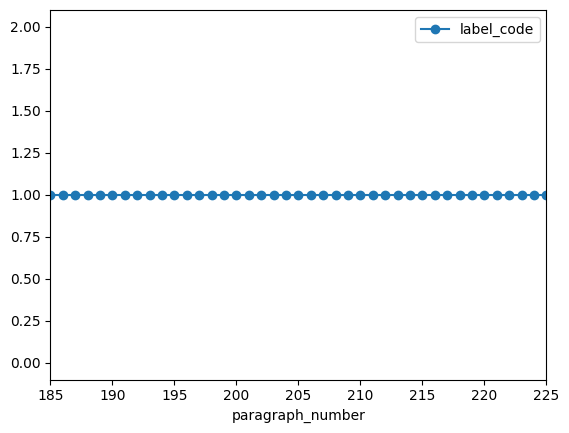

In [13]:
df.plot(kind='line', x='paragraph_number', y='label_code', style='-o')
x = 185
plt.xlim(x,x+40)
plt.show()

In [14]:
df.loc[187], df.loc[188], df.loc[194]

(filename                 ../data/annotated/journals/Mycotaxon/Vol119/s4...
 label                                                      Misc-exposition
 paragraph_number                                                       187
 page_number                                                              7
 empirical_page_number                                                  411
 line_number                                                           46.0
 body                     Singer R. 1976. Marasmieae (Basidiomycetes – T...
 label_code                                                               1
 Name: 187, dtype: object,
 filename                 ../data/annotated/journals/Mycotaxon/Vol119/s4...
 label                                                      Misc-exposition
 paragraph_number                                                       188
 page_number                                                              7
 empirical_page_number                                       

We're only interested in Nomeclature and Description paragraphs.

The long list of Nomenclatures followed by a single Nomenclature is an article with just Nomenclatures, and then the next article has a Nomenclature and two Descriptions.

In [15]:
df2 = df.loc[df['label'].isin(['Nomenclature', 'Description'])]
len(df2)

8082

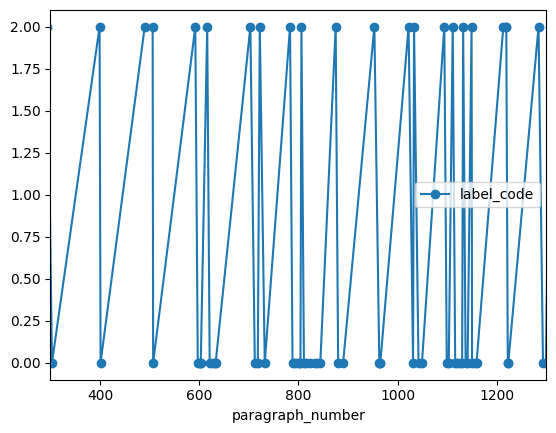

In [16]:
df2.plot(kind='line', x='paragraph_number', y='label_code', style='-o')
x = 300
plt.xlim(x,x+1000)
plt.show()

Sensible cutoffs for max distance from Nomenclature to Description appear to be above 6 or maybe above 13.

np.float64(6313.0)

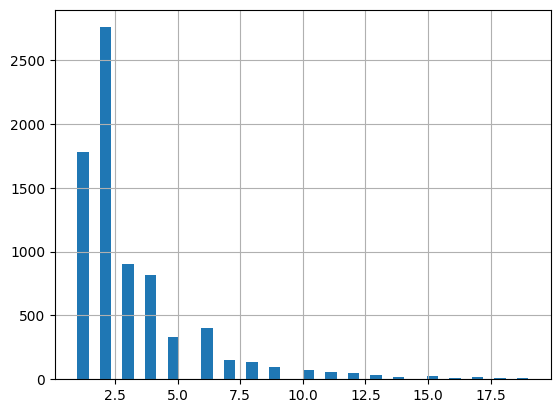

In [17]:
diffs = df2['paragraph_number'].diff()
diffs[diffs < 20].hist(bins=40)
diffs.max()

I have confirmed that the highest paragraph distance is the first nomenclature in a volume. The first and last few articles in Mycotaxon typically have no Nomenclatures.

In [18]:
df2.loc[diffs.index[diffs == 3958.0]]

,filename,label,paragraph_number,page_number,empirical_page_number,line_number,body,label_code


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import numpy as np
classifier = CalibratedClassifierCV()
vectorizer = TfidfVectorizer()
vectorize_text = vectorizer.fit_transform(df['body'])

pca = TruncatedSVD(n_components=1000)
vt2d = pca.fit_transform(vectorize_text)

sample = vectorizer.transform([df.loc[57413]['body']])
(sample, vectorize_text, vt2d)

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 0 stored elements and shape (1, 71903)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 873315 stored elements and shape (79192, 71903)>,
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00201367,  0.05906188,  0.01050156, ...,  0.00080723,
          0.0006453 , -0.00062377],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.12129958,  0.08458086,  0.01080884, ...,  0.0165671 ,
         -0.00416888,  0.04383683],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.11960887,  0.10502495,  0.03517553, ...,  0.02828149,
         -0.00342106,  0.02462565]]))

In [21]:
pca.components_

array([[ 1.49329086e-03,  1.94906718e-03,  3.26395448e-05, ...,
         2.94266547e-05,  8.02914814e-05,  1.91184192e-06],
       [ 7.28757735e-04, -1.29505373e-04, -2.62359662e-06, ...,
        -9.97067481e-06, -6.85569421e-07,  1.57832753e-06],
       [ 1.38819245e-03, -8.09573207e-04, -2.02157679e-05, ...,
         1.01392537e-04, -5.84475052e-05,  1.22405454e-05],
       ...,
       [ 5.09701358e-03,  4.10063634e-03,  2.05407046e-04, ...,
         2.52034699e-04,  4.69550461e-04, -1.01038053e-04],
       [-1.76703574e-02,  1.66262904e-03,  2.56495161e-04, ...,
        -1.22675664e-04,  9.80921182e-05,  8.09708238e-05],
       [ 5.35315917e-03, -3.40663555e-03,  2.91038055e-06, ...,
        -2.07890841e-04,  1.88336942e-04,  5.33800938e-04]])

In [22]:
pca.explained_variance_ratio_

array([0.01352744, 0.00572805, 0.0050406 , 0.00485733, 0.00471417,
       0.00396181, 0.00323547, 0.00300129, 0.00276901, 0.00272881,
       0.0026037 , 0.00242797, 0.00238641, 0.002285  , 0.00215263,
       0.00211583, 0.00202101, 0.00199321, 0.00198713, 0.00194201,
       0.00190127, 0.00185313, 0.00184238, 0.00181746, 0.00176991,
       0.0017085 , 0.00167916, 0.0016763 , 0.00164374, 0.00157774,
       0.00150633, 0.00145078, 0.00142676, 0.00137963, 0.00136537,
       0.00125245, 0.00124614, 0.00121338, 0.00118332, 0.00115027,
       0.00113625, 0.00111546, 0.00109734, 0.00107741, 0.00106459,
       0.00106348, 0.00104233, 0.00102577, 0.00102186, 0.00101287,
       0.00099108, 0.00098086, 0.00097397, 0.00096383, 0.00095563,
       0.00094639, 0.00092666, 0.00092131, 0.00091969, 0.00091259,
       0.00090435, 0.00089506, 0.00087194, 0.00085492, 0.00084726,
       0.00083914, 0.00083198, 0.0008238 , 0.00081603, 0.00080654,
       0.00079917, 0.00079832, 0.0007914 , 0.00078896, 0.00078

In [23]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
cumsum

array([0.01352744, 0.01925549, 0.02429609, 0.02915342, 0.0338676 ,
       0.03782941, 0.04106488, 0.04406618, 0.04683518, 0.049564  ,
       0.0521677 , 0.05459566, 0.05698208, 0.05926707, 0.0614197 ,
       0.06353553, 0.06555654, 0.06754975, 0.06953688, 0.07147888,
       0.07338016, 0.07523328, 0.07707567, 0.07889313, 0.08066304,
       0.08237153, 0.0840507 , 0.085727  , 0.08737074, 0.08894848,
       0.09045481, 0.09190559, 0.09333235, 0.09471199, 0.09607735,
       0.09732981, 0.09857595, 0.09978933, 0.10097265, 0.10212291,
       0.10325916, 0.10437462, 0.10547196, 0.10654937, 0.10761396,
       0.10867744, 0.10971977, 0.11074554, 0.1117674 , 0.11278027,
       0.11377135, 0.1147522 , 0.11572617, 0.11669   , 0.11764563,
       0.11859202, 0.11951868, 0.12043999, 0.12135969, 0.12227228,
       0.12317663, 0.12407169, 0.12494362, 0.12579854, 0.1266458 ,
       0.12748494, 0.12831692, 0.12914072, 0.12995675, 0.13076329,
       0.13156246, 0.13236078, 0.13315218, 0.13394115, 0.13472

In [25]:
reint = []
for a in ['base', 'latinate', 'suffix', 'punctuation', 'year', 'abbrev']:
    reint.append(pd.read_csv('../results/reinterpret/%s.csv' % a))
    reint[-1]['reinterpretation'] = a
reint_df = pd.concat(reint)

In [26]:
pd.set_option('display.max_rows', 500)
gb = reint_df.groupby(['reinterpretation', 'label'])
reint_df.loc[gb['f1'].idxmax()].sort_values('f1')

,classifier,vectorizer,time,label,precision,recall,f1,support,reinterpretation
62,SGDClassifier,CountVectorizer,0.914251,Nomenclature,0.943119,0.536534,0.683965,958,abbrev
62,SGDClassifier,CountVectorizer,1.099240,Nomenclature,0.950680,0.583507,0.723157,958,punctuation
8,RandomForestClassifier,CountVectorizer,15.877190,Nomenclature,0.899859,0.665971,0.765447,958,abbrev
53,PassiveAggressiveClassifier,TfidfVectorizer,0.926075,Nomenclature,0.825511,0.716075,0.766909,958,abbrev
53,PassiveAggressiveClassifier,TfidfVectorizer,0.926075,Nomenclature,0.825511,0.716075,0.766909,958,abbrev
50,PassiveAggressiveClassifier,CountVectorizer,0.924095,Nomenclature,0.857322,0.715031,0.779738,958,abbrev
68,OneVsRestClassifier,CountVectorizer,141.465091,Nomenclature,0.796095,0.766180,0.780851,958,abbrev
62,SGDClassifier,CountVectorizer,0.864839,Nomenclature,0.892208,0.717119,0.795139,958,latinate
8,RandomForestClassifier,CountVectorizer,13.375148,Nomenclature,0.917001,0.715031,0.803519,958,suffix
62,SGDClassifier,CountVectorizer,0.849932,Nomenclature,0.891521,0.746347,0.812500,958,suffix


In [27]:
punct_df = reint_df.loc[reint_df['reinterpretation'] == 'punctuation'].sort_values(['classifier', 'vectorizer', 'label'])
punct_df.sort_values('f1')

,classifier,vectorizer,time,label,precision,recall,f1,support,reinterpretation
44,DummyClassifier,CountVectorizer,1.021250,Nomenclature,0.073271,0.074113,0.073690,958,punctuation
47,DummyClassifier,TfidfVectorizer,1.047276,Nomenclature,0.073271,0.074113,0.073690,958,punctuation
45,DummyClassifier,TfidfVectorizer,1.047276,Description,0.079952,0.081907,0.080918,818,punctuation
42,DummyClassifier,CountVectorizer,1.021250,Description,0.079952,0.081907,0.080918,818,punctuation
5,BernoulliNB,TfidfVectorizer,1.092380,Nomenclature,0.858427,0.398747,0.544547,958,punctuation
2,BernoulliNB,CountVectorizer,1.084643,Nomenclature,0.858427,0.398747,0.544547,958,punctuation
12,AdaBoostClassifier,CountVectorizer,4.175057,Description,0.600559,0.788509,0.681818,818,punctuation
14,AdaBoostClassifier,CountVectorizer,4.175057,Nomenclature,0.839820,0.585595,0.690037,958,punctuation
0,BernoulliNB,CountVectorizer,1.084643,Description,0.690844,0.710269,0.700422,818,punctuation
3,BernoulliNB,TfidfVectorizer,1.092380,Description,0.690844,0.710269,0.700422,818,punctuation


In [28]:
base_df = reint_df.loc[reint_df['reinterpretation'] == 'base'].sort_values(['classifier', 'vectorizer', 'label'])
base_df.sort_values('f1')

,classifier,vectorizer,time,label,precision,recall,f1,support,reinterpretation
44,DummyClassifier,CountVectorizer,1.280834,Nomenclature,0.073271,0.074113,0.073690,958,base
47,DummyClassifier,TfidfVectorizer,1.310310,Nomenclature,0.073271,0.074113,0.073690,958,base
45,DummyClassifier,TfidfVectorizer,1.310310,Description,0.079952,0.081907,0.080918,818,base
42,DummyClassifier,CountVectorizer,1.280834,Description,0.079952,0.081907,0.080918,818,base
5,BernoulliNB,TfidfVectorizer,1.402291,Nomenclature,0.815789,0.258873,0.393027,958,base
2,BernoulliNB,CountVectorizer,1.365536,Nomenclature,0.815789,0.258873,0.393027,958,base
14,AdaBoostClassifier,CountVectorizer,4.264124,Nomenclature,0.819005,0.377871,0.517143,958,base
12,AdaBoostClassifier,CountVectorizer,4.264124,Description,0.504710,0.786064,0.614723,818,base
26,GradientBoostingClassifier,CountVectorizer,25.869762,Nomenclature,0.895270,0.553236,0.683871,958,base
17,AdaBoostClassifier,TfidfVectorizer,5.760363,Nomenclature,0.764331,0.626305,0.688468,958,base


In [31]:
medians = gb[['f1']].median()
medians - medians.loc['base']

f1
reinterpretation label                    
abbrev           Description     -0.001727
                 Misc-exposition -0.007264
                 Nomenclature    -0.109862
base             Description      0.000000
                 Misc-exposition  0.000000
                 Nomenclature     0.000000
latinate         Description     -0.008431
                 Misc-exposition -0.001839
                 Nomenclature    -0.010390
punctuation      Description      0.005244
                 Misc-exposition  0.002954
                 Nomenclature     0.040396
suffix           Description     -0.009482
                 Misc-exposition -0.000939
                 Nomenclature    -0.018250
year             Description      0.001344
                 Misc-exposition  0.002176
                 Nomenclature     0.030352

In [34]:
df_P18_19 = pd.read_csv('../results/training_growth/M55_58_M117_119_P17_19.csv')
df_P19 = pd.read_csv('../results/training_growth/M55_58_M117_119_P19.csv')
df_M119 = pd.read_csv('../results/training_growth/M55_58_M117_119.csv')
df_M55 = pd.read_csv('../results/training_growth/M55.csv')

In [35]:
df_P18_19[df_P18_19['label'] == 'Nomenclature'].describe()

,time,precision,recall,f1,support
count,26.000000,26.000000,26.000000,26.000000,26.0
mean,63.977336,0.818330,0.739902,0.774491,1394.0
std,173.407649,0.219118,0.220078,0.216304,0.0
min,2.187869,0.085983,0.085366,0.085673,1394.0
25%,2.409659,0.864000,0.734397,0.800200,1394.0
50%,10.787453,0.880705,0.832138,0.857646,1394.0
75%,21.874141,0.902887,0.869082,0.880354,1394.0
max,754.709156,0.940678,0.893113,0.907132,1394.0


In [36]:
df_P19[df_P19['label'] == 'Nomenclature'].describe()

,time,precision,recall,f1,support
count,26.000000,26.000000,26.000000,26.000000,26.0
mean,16.874326,0.816829,0.629916,0.696756,1019.0
std,31.713654,0.217431,0.242429,0.232820,0.0
min,1.396338,0.096614,0.095191,0.095897,1019.0
25%,1.479222,0.825342,0.561580,0.694119,1019.0
50%,5.286664,0.890867,0.731109,0.798369,1019.0
75%,14.327276,0.907095,0.807655,0.848141,1019.0
max,129.893550,0.940367,0.855741,0.870694,1019.0


In [37]:
df_M119[df_M119['label'] == 'Nomenclature'].describe()

,time,precision,recall,f1,support
count,26.000000,26.000000,26.000000,26.000000,26.0
mean,17.284947,0.809594,0.670994,0.724987,960.0
std,36.050970,0.224738,0.227373,0.222238,0.0
min,0.918383,0.077154,0.080208,0.078652,960.0
25%,1.015808,0.852254,0.597917,0.698917,960.0
50%,5.019204,0.883247,0.763542,0.827168,960.0
75%,10.745590,0.903883,0.823437,0.851625,960.0
max,153.536493,0.945746,0.859375,0.866177,960.0


In [38]:
df_M55[df_M55['label'] == 'Nomenclature'].describe()

,time,precision,recall,f1,support
count,26.000000,26.000000,26.000000,26.000000,26.0
mean,1.037260,0.718909,0.505818,0.584684,119.0
std,1.735815,0.291658,0.234838,0.254026,0.0
min,0.140541,0.071429,0.008403,0.015038,119.0
25%,0.152904,0.724845,0.485294,0.593350,119.0
50%,0.364112,0.817695,0.584034,0.692897,119.0
75%,0.812031,0.880544,0.672269,0.746708,119.0
max,7.786701,0.970149,0.764706,0.779343,119.0


In [43]:
df_nom_P18_19 = pd.read_csv('../results/nomenclature/55_56_57_58_117_118_119_P_18_19.csv')
df_nom_P18_19[df_nom_P18_19['label'] == 'Nomenclature'].describe()

,time,precision,recall,f1,support
count,26.000000,26.000000,26.000000,26.000000,26.0
mean,22.920577,0.845370,0.742015,0.786278,1156.0
std,48.864608,0.228435,0.220320,0.218219,0.0
min,1.727870,0.080560,0.079585,0.080070,1156.0
25%,1.872452,0.873888,0.726860,0.801603,1156.0
50%,7.138059,0.906708,0.817474,0.865988,1156.0
75%,12.214895,0.932130,0.857915,0.891161,1156.0
max,183.091805,0.969062,0.932526,0.907594,1156.0


In [44]:
df_nom_P18_19.sort_values('f1')

,classifier,vectorizer,time,label,precision,recall,f1,support
47,DummyClassifier,TfidfVectorizer,1.767820,Nomenclature,0.080560,0.079585,0.080070,1156
44,DummyClassifier,CountVectorizer,1.727870,Nomenclature,0.080560,0.079585,0.080070,1156
42,DummyClassifier,CountVectorizer,1.727870,Description,0.086538,0.092871,0.089593,1066
45,DummyClassifier,TfidfVectorizer,1.767820,Description,0.086538,0.092871,0.089593,1066
2,BernoulliNB,CountVectorizer,1.845306,Nomenclature,0.890370,0.519896,0.656472,1156
5,BernoulliNB,TfidfVectorizer,1.882439,Nomenclature,0.890370,0.519896,0.656472,1156
15,AdaBoostClassifier,TfidfVectorizer,7.810416,Description,0.674658,0.739212,0.705461,1066
12,AdaBoostClassifier,CountVectorizer,5.519257,Description,0.712316,0.727017,0.719591,1066
3,BernoulliNB,TfidfVectorizer,1.882439,Description,0.721038,0.729831,0.725408,1066
0,BernoulliNB,CountVectorizer,1.845306,Description,0.721038,0.729831,0.725408,1066
